In [1]:
import yfinance as yf
import pandas as pd
from prophet import Prophet

In [2]:
ibovespa = yf.Ticker("^BVSP")
ibovespa.info

{'maxAge': 86400,
 'priceHint': 2,
 'previousClose': 130649.0,
 'regularMarketPreviousClose': 130649.0,
 'averageVolume': 10994528,
 'averageVolume10days': 9029190,
 'averageDailyVolume10Day': 9029190,
 'fiftyTwoWeekHigh': 134392.0,
 'fiftyDayAverage': 126686.36,
 'twoHundredDayAverage': 116847.71,
 'currency': 'BRL',
 'exchange': 'SAO',
 'quoteType': 'INDEX',
 'symbol': '^BVSP',
 'underlyingSymbol': '^BVSP',
 'shortName': 'IBOVESPA',
 'longName': 'IBOVESPA',
 'firstTradeDateEpochUtc': 735915600,
 'timeZoneFullName': 'America/Sao_Paulo',
 'timeZoneShortName': 'BRT',
 'uuid': 'd9d25d96-d9ea-3b77-bca7-9e274228b02e',
 'messageBoardId': 'finmb_INDEXBVSP',
 'gmtOffSetMilliseconds': -10800000,
 'trailingPegRatio': None}

In [3]:
df = ibovespa.history(period="1y")
df["ds"] = df.index.date
df["y"] = df["Close"]
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits,ds,y
Date,,,,,,,,,
2023-01-12 00:00:00-03:00,112516.0,113129.0,110982.0,111877.0,19839100,0.0,0.0,2023-01-12,111877.0
2023-01-13 00:00:00-03:00,111843.0,111847.0,110428.0,110916.0,15939000,0.0,0.0,2023-01-13,110916.0
2023-01-16 00:00:00-03:00,110908.0,110908.0,108753.0,109213.0,12512400,0.0,0.0,2023-01-16,109213.0
2023-01-17 00:00:00-03:00,109214.0,111577.0,109214.0,111439.0,14363200,0.0,0.0,2023-01-17,111439.0
2023-01-18 00:00:00-03:00,111442.0,113306.0,111441.0,112452.0,14128600,0.0,0.0,2023-01-18,112452.0
...,...,...,...,...,...,...,...,...,...
2024-01-08 00:00:00-03:00,132023.0,132498.0,131015.0,132427.0,8497500,0.0,0.0,2024-01-08,132427.0
2024-01-09 00:00:00-03:00,132424.0,132426.0,131203.0,131447.0,9287500,0.0,0.0,2024-01-09,131447.0
2024-01-10 00:00:00-03:00,131447.0,131628.0,130438.0,130841.0,8958400,0.0,0.0,2024-01-10,130841.0


In [4]:
m = Prophet()
m.fit(df)

21:59:33 - cmdstanpy - INFO - Chain [1] start processing
21:59:33 - cmdstanpy - INFO - Chain [1] done processing


In [5]:
future = m.make_future_dataframe(periods=7)
future.tail()

,ds
251,2024-01-15
252,2024-01-16
253,2024-01-17
254,2024-01-18
255,2024-01-19


In [6]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
251,2024-01-15,136098.821232,133611.680399,138733.163418
252,2024-01-16,136461.341890,133985.045493,138837.816011
253,2024-01-17,136736.494622,134500.092776,139105.788412
254,2024-01-18,136963.764261,134459.779749,139488.759332
255,2024-01-19,137186.532058,134734.581238,139787.641195


/Users/lucas.marques/Projects/data_analytics/.venv/lib/python3.11/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/lucas.marques/Projects/data_analytics/.venv/lib/python3.11/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


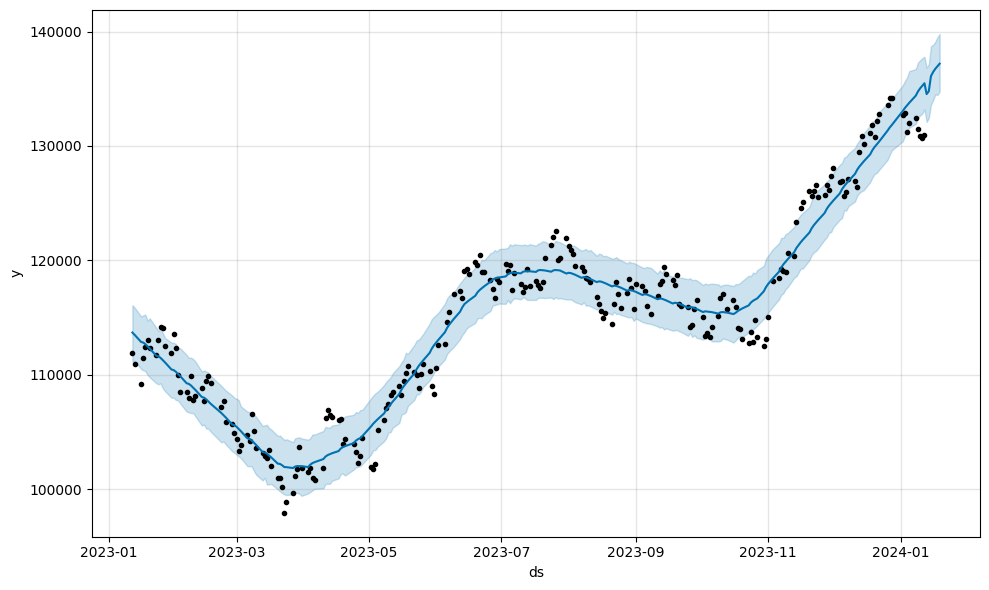

In [7]:
fig1 = m.plot(forecast)

/Users/lucas.marques/Projects/data_analytics/.venv/lib/python3.11/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()


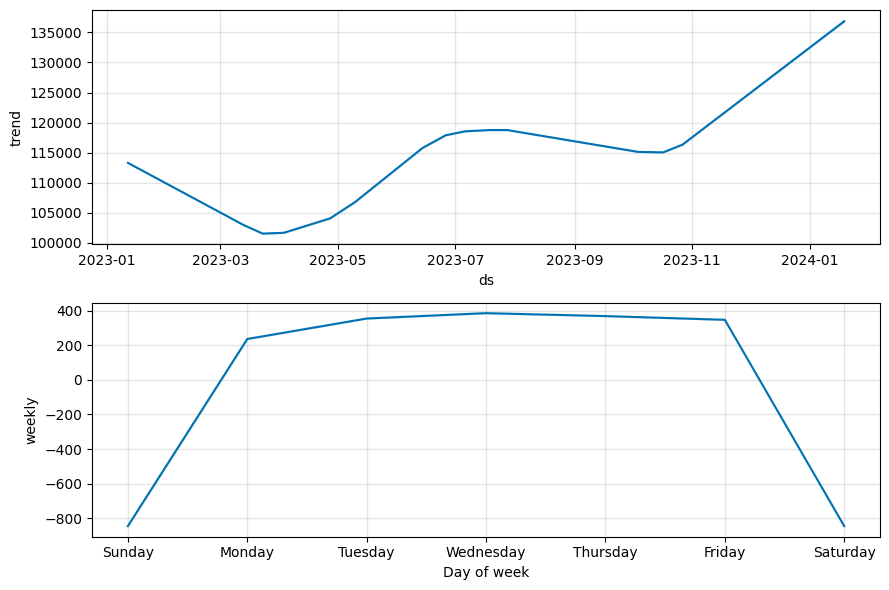

In [8]:
fig2 = m.plot_components(forecast)

{'address1': 'One Apple Park Way',
 'city': 'Cupertino',
 'state': 'CA',
 'zip': '95014',
 'country': 'United States',
 'phone': '408 996 1010',
 'website': 'https://www.apple.com',
 'industry': 'Consumer Electronics',
 'industryKey': 'consumer-electronics',
 'industryDisp': 'Consumer Electronics',
 'sector': 'Technology',
 'sectorKey': 'technology',
 'sectorDisp': 'Technology',
 'longBusinessSummary': 'Apple Inc. designs, manufactures, and markets smartphones, personal computers, tablets, wearables, and accessories worldwide. The company offers iPhone, a line of smartphones; Mac, a line of personal computers; iPad, a line of multi-purpose tablets; and wearables, home, and accessories comprising AirPods, Apple TV, Apple Watch, Beats products, and HomePod. It also provides AppleCare support and cloud services; and operates various platforms, including the App Store that allow customers to discover and download applications and digital content, such as books, music, video, games, and pod

In [47]:
# Get live stock data
aapl = yf.Ticker("AAPL")
share = aapl.info
share["open"]

186.06